# Symbolic Aggregate Approximation & Piecewise Aggregate Approximation 

## SAX-PAA или верните мне мой 2007 

Оригинал статьи - https://cs.gmu.edu/~jessica/SAX_DAMI_preprint.pdf

Довольно старая работа, посвященная предобработке временного ряда с целью снижения размерности и сохранения информации об основных паттернах. Изначально предполагалось использовать для анализа финансовых временных рядов, но по факту используется в разных приложениях как один из возможных этапов препроцессинга. 

Основная идея метода заключается в том, что он преобразует временной ряд в низкоразмерный массив символов или чисел. Он состоит из двух шагов: сначала "кусочно-агрегатное" приближение (PAA) применяется к исходным данным для эффективного уменьшения размерности. Затем значения PAA дополнительно дискретизируются на фиксированное количество возможных значений с использованием гауссовых свойств значений z-нормированного временного ряда. По сути, среди значений PAA мы ищем значения, которые близки друг к другу, и маркируем их буквой (если мы используем строковое представление) или числом (если мы используем порядковое представление). Более подробное описание алгоритма можно найти [здесь](https://jmotif.github.io/sax-vsm_site/morea/algorithm/SAX.html).

Внезапное и очень прикольное свойство - полученные буквенные представления временных рядов можно действительно рассматривать как "слова" и использовать привычные нам NLP методы для работы. Например, для разных временных рядов можно нагенерировать тестовые SAX представления, посчитать между ними расстояния Левенштейна и найти наиболее похожие по паттернам временные ряды. Или вообще засунуть в tf-idf, нагенерировать векторные представления и вот вам новое признаковое пространство, которое учитывает особенности паттернов во временных рядах.

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import numpy as np
import string
import matplotlib.pyplot as plt
import seaborn as sns

from tslearn.generators import random_walks
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.piecewise import PiecewiseAggregateApproximation
from tslearn.piecewise import SymbolicAggregateApproximation
from tslearn.clustering import TimeSeriesKMeans, silhouette_score

Для работы PAA необходимо сначала z-нормализовать наши данные. Годное описание принципов работы PAA можно найти [здесь](https://vigne.sh/posts/piecewise-aggregate-approx/)

In [4]:
np.random.seed(0)
# Generate a random walk time series
n_ts, sz, d = 1, 100, 1
dataset = random_walks(n_ts=n_ts, sz=sz, d=d)
scaler = TimeSeriesScalerMeanVariance(mu=0., std=1.)  # Rescale time series
dataset = scaler.fit_transform(dataset)

# PAA transform (and inverse transform) of the data
n_paa_segments = 10
paa = PiecewiseAggregateApproximation(n_segments=n_paa_segments)
paa_dataset_inv = paa.inverse_transform(paa.fit_transform(dataset))

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [5]:
paa.transform(dataset)

array([[[-0.01208612],
        [ 0.99632313],
        [ 1.0306829 ],
        [ 1.36363721],
        [ 0.7076021 ],
        [-0.02530004],
        [-0.91802305],
        [-1.31387456],
        [-1.38330975],
        [-0.44565183]]])

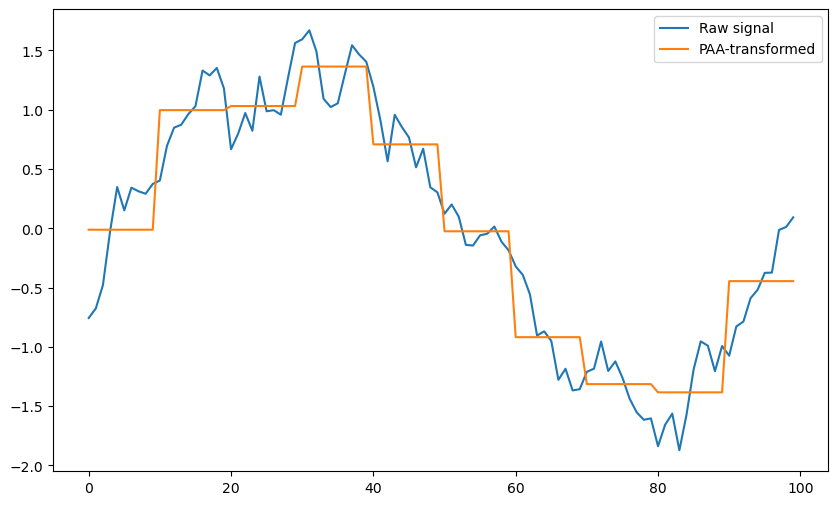

In [6]:
plt.figure(figsize=(10, 6))
plt.plot(dataset.ravel(), label='Raw signal')
plt.plot(paa_dataset_inv.ravel(), label='PAA-transformed')
plt.legend()
plt.show()

In [7]:
# SAX transform
n_sax_symbols = 8
sax = SymbolicAggregateApproximation(
    n_segments=n_paa_segments,
    alphabet_size_avg=n_sax_symbols
)
sax_dataset_inv = sax.inverse_transform(sax.fit_transform(dataset))

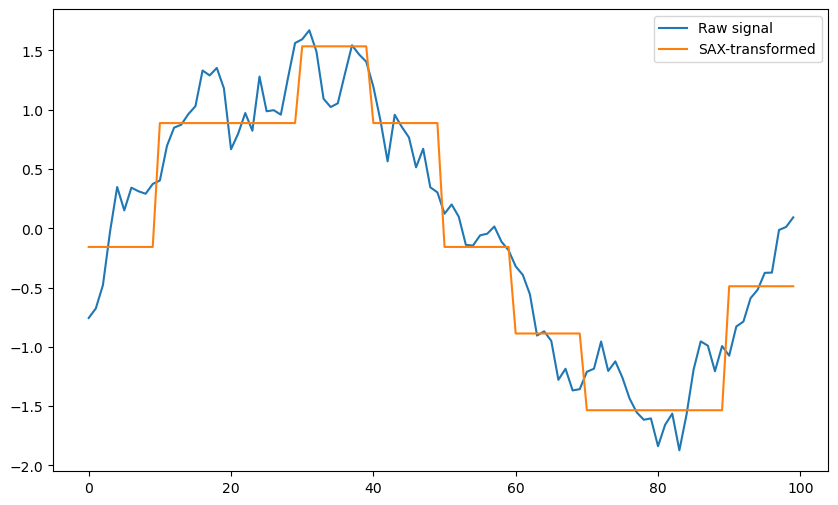

In [9]:
plt.figure(figsize=(10, 6))
plt.plot(dataset.ravel(), label='Raw signal')
plt.plot(sax_dataset_inv.ravel(), label='SAX-transformed')
plt.legend()
# plt.savefig('../Presentation/img/SAX-PAA.png')
plt.show()

In [10]:
sax_numeric_representation = sax.transform(dataset).ravel()
sax_numeric_representation

array([3, 6, 6, 7, 6, 3, 1, 0, 0, 2])

In [13]:
sax_alphabet = list(string.ascii_lowercase[:n_sax_symbols])

sax_alphabet_map = dict(zip(range(n_sax_symbols), sax_alphabet))

sax_string_representation = [sax_alphabet_map[number] for number in sax_numeric_representation]
sax_string_representation = "".join(sax_string_representation)
sax_string_representation

'dgghgdbaac'

In [41]:
def get_string_sax(sax_numeric_representation, n_sax_symbols):
    
    sax_alphabet = list(string.ascii_lowercase[:n_sax_symbols])
    sax_alphabet_map = dict(zip(range(n_sax_symbols), sax_alphabet))

    sax_string_representation = [sax_alphabet_map[number] for number in sax_numeric_representation]
    sax_string_representation = "".join(sax_string_representation)
    return sax_string_representation

# Пример на наших игрушечных

In [12]:
x1 = np.arange(0, 50, 0.1)
x2 = np.arange(50, 100, 0.1)

location_shift = np.concatenate((
        np.random.normal(loc=0.0, size=len(x1)), 
        np.random.normal(loc=5.0, size=len(x2))))

scale_shift = np.concatenate((
        np.random.normal(loc=0.0, scale=1.0, size=len(x1)), 
        np.random.normal(loc=0.0, scale=4.0, size=len(x2))
    ))

seasonality_shift = np.concatenate((
        np.sin(x1) + np.random.normal(loc=0.0, scale=.2, size=len(x1)), 
        np.sin(x2/2) + np.random.normal(loc=0.0, scale=.2, size=len(x2)))
    )

shifts = [location_shift, scale_shift, seasonality_shift]

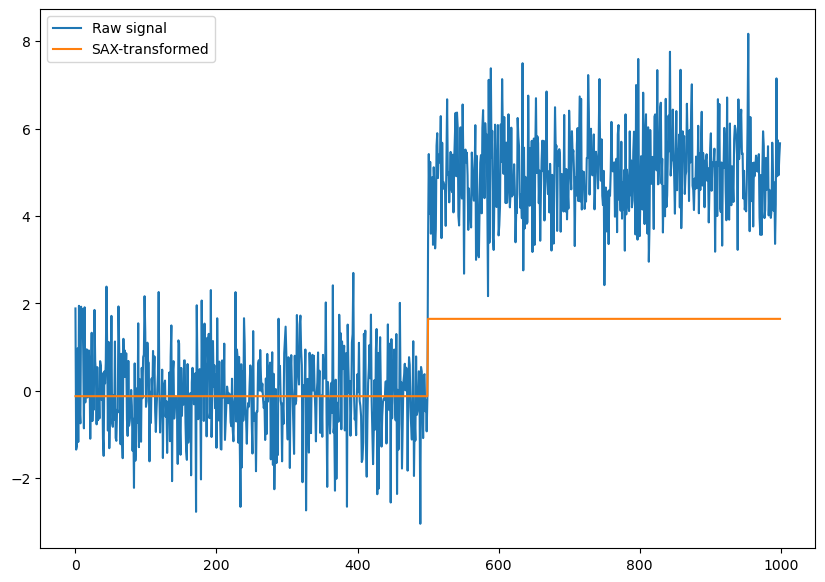

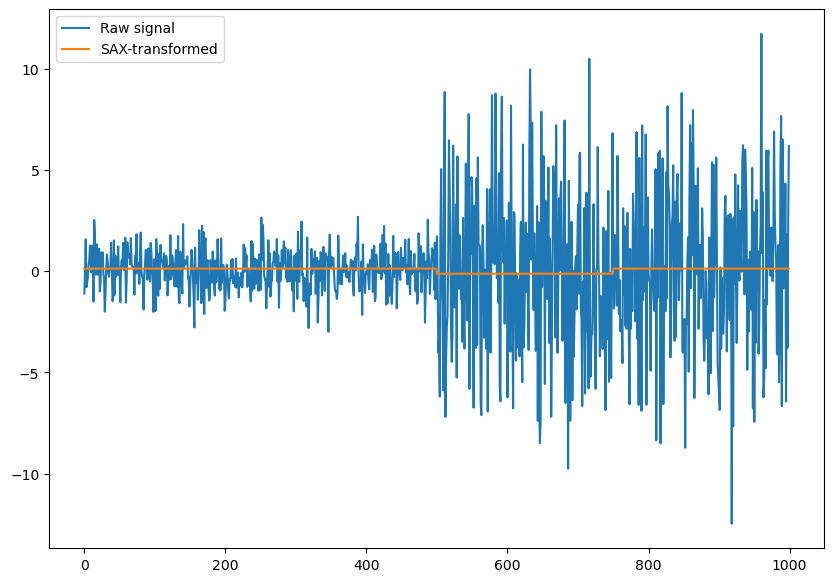

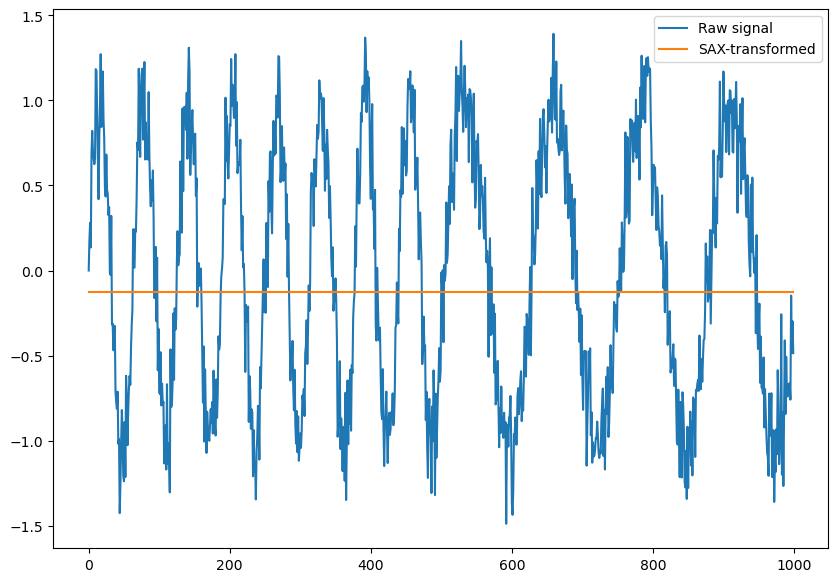

In [13]:
for shift in shifts:
    # SAX transform
    n_paa_segments = 4
    n_sax_symbols = 10
    sax = SymbolicAggregateApproximation(n_segments=n_paa_segments,
                                         alphabet_size_avg=n_sax_symbols)
    sax_dataset_inv = sax.inverse_transform(sax.fit_transform(shift.reshape(-1, 1).T))
    #print(sax.fit_transform(shift.reshape(-1, 1).T))

    plt.figure(figsize=(10, 7))
    plt.plot(shift, label='Raw signal')
    plt.plot(sax_dataset_inv.ravel(), label='SAX-transformed')
    plt.legend()
    plt.show()

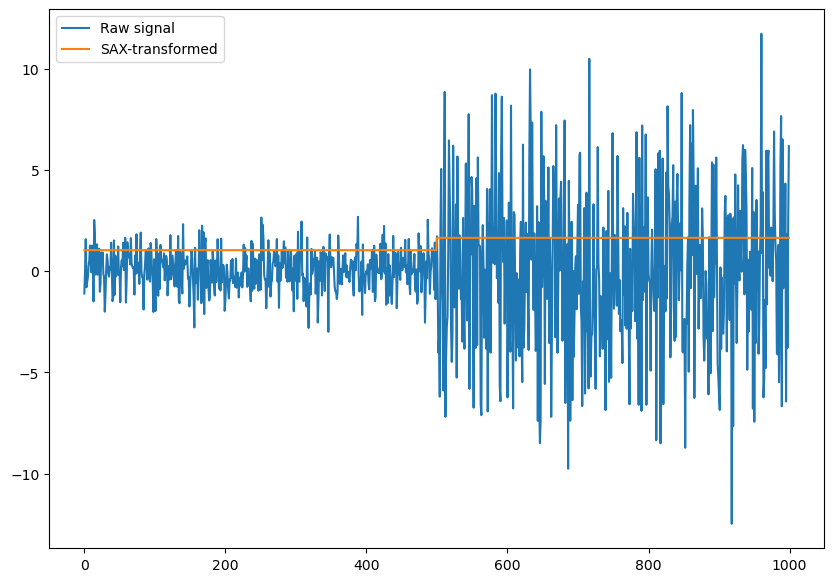

In [14]:
n_paa_segments = 4
n_sax_symbols = 10
sax = SymbolicAggregateApproximation(n_segments=n_paa_segments,
										alphabet_size_avg=n_sax_symbols)
sax_dataset_inv = sax.inverse_transform(sax.fit_transform((scale_shift**2).reshape(-1, 1).T))

plt.figure(figsize=(10, 7))
plt.plot((scale_shift), label='Raw signal')
plt.plot(sax_dataset_inv.ravel(), label='SAX-transformed')
plt.legend()
plt.show()

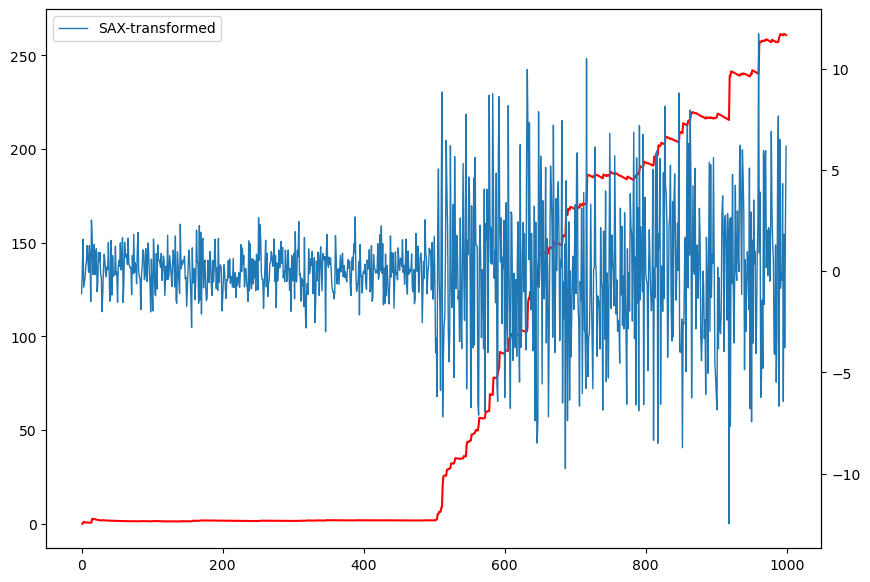

In [47]:
var_scale_shift = np.ndarray(0)
for i in range(scale_shift.shape[0]):
    var_scale_shift = np.append(var_scale_shift, (scale_shift[:i]**2).var())

fig, ax = plt.subplots(figsize=(10, 7))
ax2 = ax.twinx()

ax.plot(var_scale_shift, color='r', label='Raw signal')
ax2.plot(scale_shift, linewidth=1, label='SAX-transformed')
plt.legend()
plt.show()

---
# Пример сжатия размерности

(И еще один интересный пример для финансов - https://peijin.medium.com/using-sax-vsm-for-financial-time-series-classification-stock-prediction-38b4d10eeb19)

In [16]:
import pandas as pd
from tqdm.auto import tqdm

In [17]:
full_ticker_df = pd.read_csv("data/full_ticker_df_month.csv", index_col=0)
datetime_columns = pd.to_datetime(full_ticker_df.columns[5:])
full_ticker_df.columns = list(full_ticker_df.columns[:5]) + list(datetime_columns)

In [18]:
full_ticker_df = full_ticker_df.iloc[:, :-1]
prices = full_ticker_df.iloc[:, 5:].T
prices = prices.fillna(method='backfill')
prices = prices.fillna(method='ffill')
full_ticker_df = full_ticker_df.iloc[:, :5].join(prices.T)

full_ticker_df.dropna(inplace=True)
full_ticker_df.shape

(96, 28)

In [19]:
scaler = TimeSeriesScalerMeanVariance(mu=0., std=1.)  # Rescale time series
tickers_scaled = scaler.fit_transform(full_ticker_df.iloc[:, 5:].values)

In [20]:
tickers_scaled.shape

(96, 23, 1)

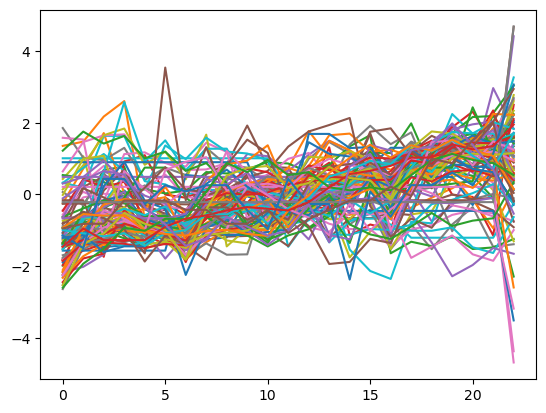

In [21]:
plt.plot(tickers_scaled[:, :, 0].T);

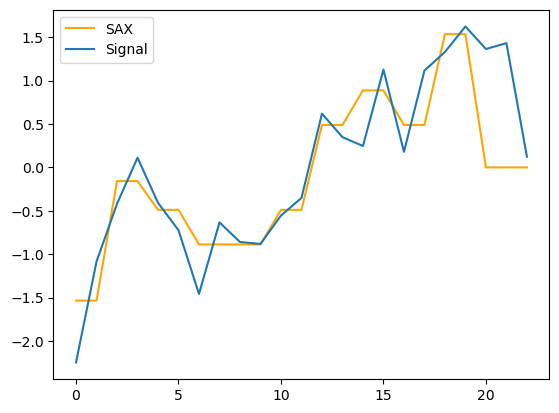

In [23]:
# SAX transform
n_paa_segments = 10
n_sax_symbols = 8
sax = SymbolicAggregateApproximation(n_segments=n_paa_segments,
                                    alphabet_size_avg=n_sax_symbols)
sax_dataset_inv = sax.inverse_transform(sax.fit_transform(tickers_scaled))

plt.plot(sax_dataset_inv[0].ravel(), color='orange', label='SAX')
plt.plot(tickers_scaled[0, :, 0], label='Signal')
plt.legend()
plt.show()

In [24]:
tickers_scaled.shape

(96, 23, 1)

In [25]:
sax_transformed = sax.fit_transform(tickers_scaled)[:, :, 0]
sax_transformed.shape

(96, 10)

  0%|          | 0/8 [00:00<?, ?it/s]

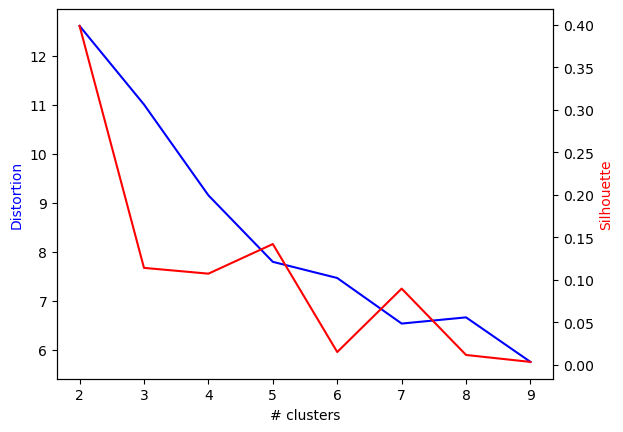

In [26]:
distortions = []
silhouette = []
K = range(2, 10)
for k in tqdm(K):
    kmeanModel = TimeSeriesKMeans(n_clusters=k, metric="dtw", n_jobs=6, max_iter=10)
    kmeanModel.fit(sax_transformed)
    distortions.append(kmeanModel.inertia_)
    silhouette.append(silhouette_score(tickers_scaled, kmeanModel.labels_, metric="dtw"))

    
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(K, distortions, 'b-')
ax2.plot(K, silhouette, 'r-')

ax1.set_xlabel('# clusters')
ax1.set_ylabel('Distortion', color='b')
ax2.set_ylabel('Silhouette', color='r')

plt.show()

In [34]:
n_clusters = 5

ts_kmeans_dtw = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw", n_jobs=6, max_iter=10)
ts_kmeans_dtw.fit(sax_transformed)

TimeSeriesKMeans(max_iter=10, metric='dtw', n_clusters=5, n_jobs=6)

In [35]:
from sklearn.linear_model import LinearRegression

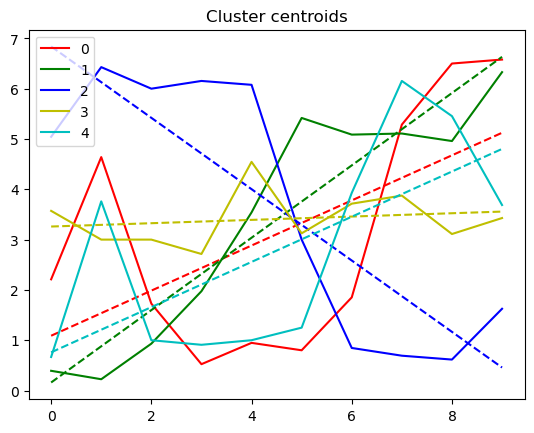

In [36]:
x = np.arange(0, len(ts_kmeans_dtw.cluster_centers_[0, :, 0].T))
colors = ['r', 'g', 'b', 'y', 'c', 'm']
for cluster_number in range(n_clusters):
    plt.plot(ts_kmeans_dtw.cluster_centers_[cluster_number, :, 0].T, label=cluster_number, color=colors[cluster_number])
    model = LinearRegression()
    model.fit(x.reshape(-1, 1), ts_kmeans_dtw.cluster_centers_[cluster_number, :, 0].T)
    y_pred = model.predict(x.reshape(-1, 1))
    plt.plot(x, y_pred, linestyle='--', color=colors[cluster_number])
plt.title("Cluster centroids")
plt.legend()
plt.show()

In [37]:
full_ticker_df['cluster'] = ts_kmeans_dtw.predict(sax_transformed)
pd.DataFrame(full_ticker_df.groupby('cluster')['sector'].value_counts())

count
cluster sector                       
0       Healthcare                  4
        Energy                      3
        Real Estate                 3
        Financial Services          2
        Industrials                 2
        Basic Materials             1
        Communication Services      1
        Consumer Cyclical           1
        Consumer Defensive          1
        Technology                  1
1       Technology                 11
        Consumer Cyclical           7
        Financial Services          6
        Healthcare                  6
        Industrials                 5
        Energy                      4
        Communication Services      2
        Consumer Defensive          2
        Basic Materials             1
        Real Estate                 1
        Utilities                   1
2       Healthcare                  5
        Communication Services      3
        Consumer Cyclical           1
        Consumer Defensive          1
        Energy                      1
        Industrials                 1
        Technology                  1
3       Healthcare                  2
        Consumer Defensive          1
        Financial Services          1
        Industrials                 1
        Real Estate                 1
        Technology                  1
4       Technology                  4
        Healthcare                  3
        Financial Services          2
        Consumer Cyclical           1
        Consumer Defensive          1

In [40]:
def plot_cluster_tickers(current_cluster):
    fig, ax = plt.subplots(
        int(np.ceil(current_cluster.shape[0]/4)),
        4,
        figsize=(15, 3*int(np.ceil(current_cluster.shape[0]/4)))
    )
    fig.autofmt_xdate(rotation=45)
    ax = ax.reshape(-1)

    for index, (_, row) in enumerate(current_cluster.iterrows()):
        ax[index].plot(row.iloc[5:-1])
        ax[index].set_title(f"{row.shortName}\n{row.sector}")
        plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

                          Cluster number: 0


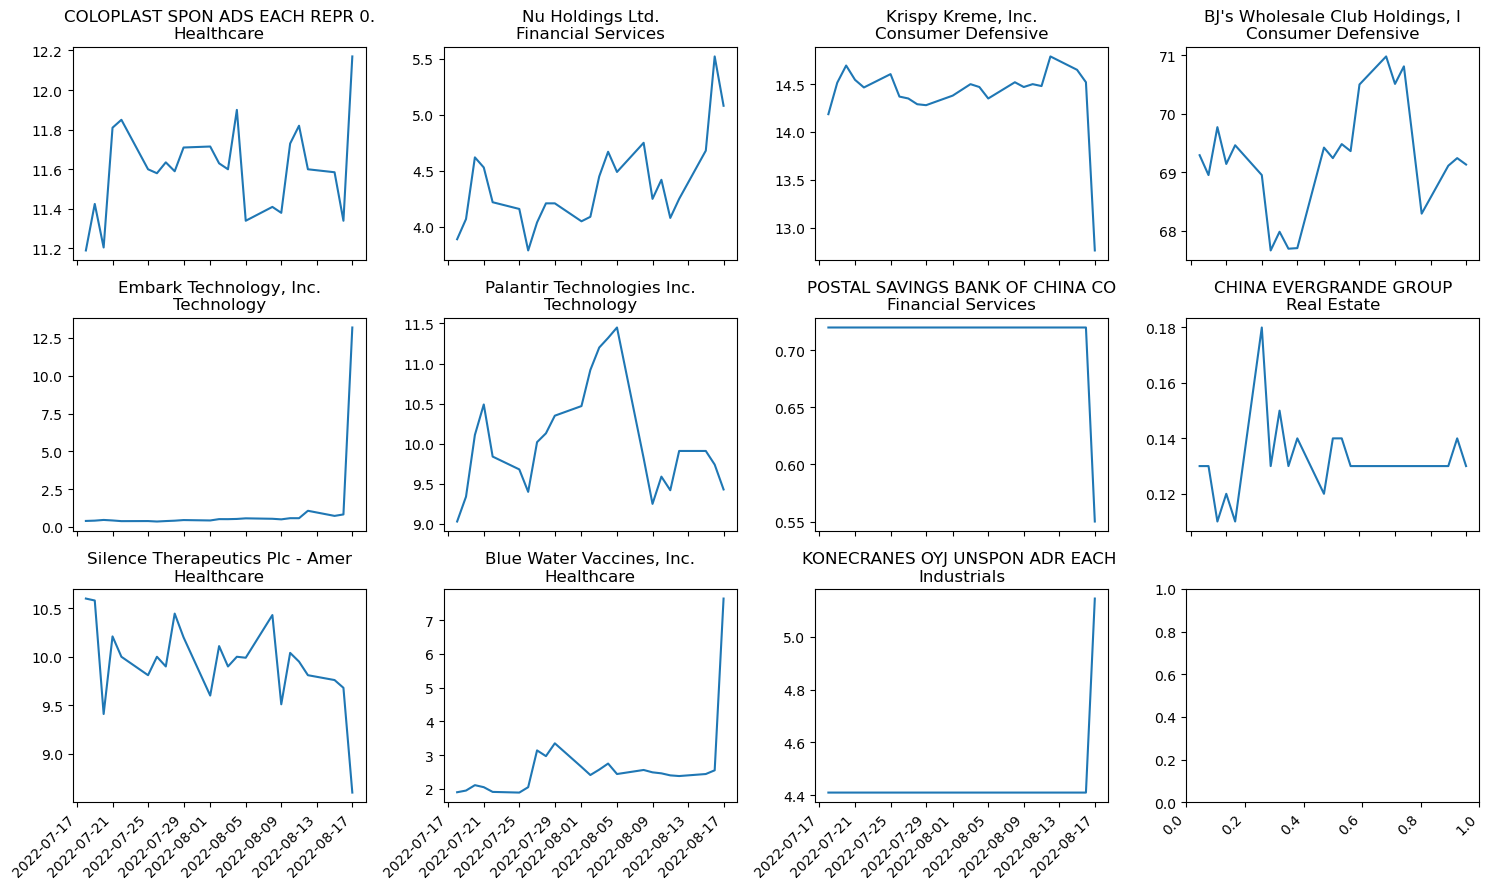

                          Cluster number: 1


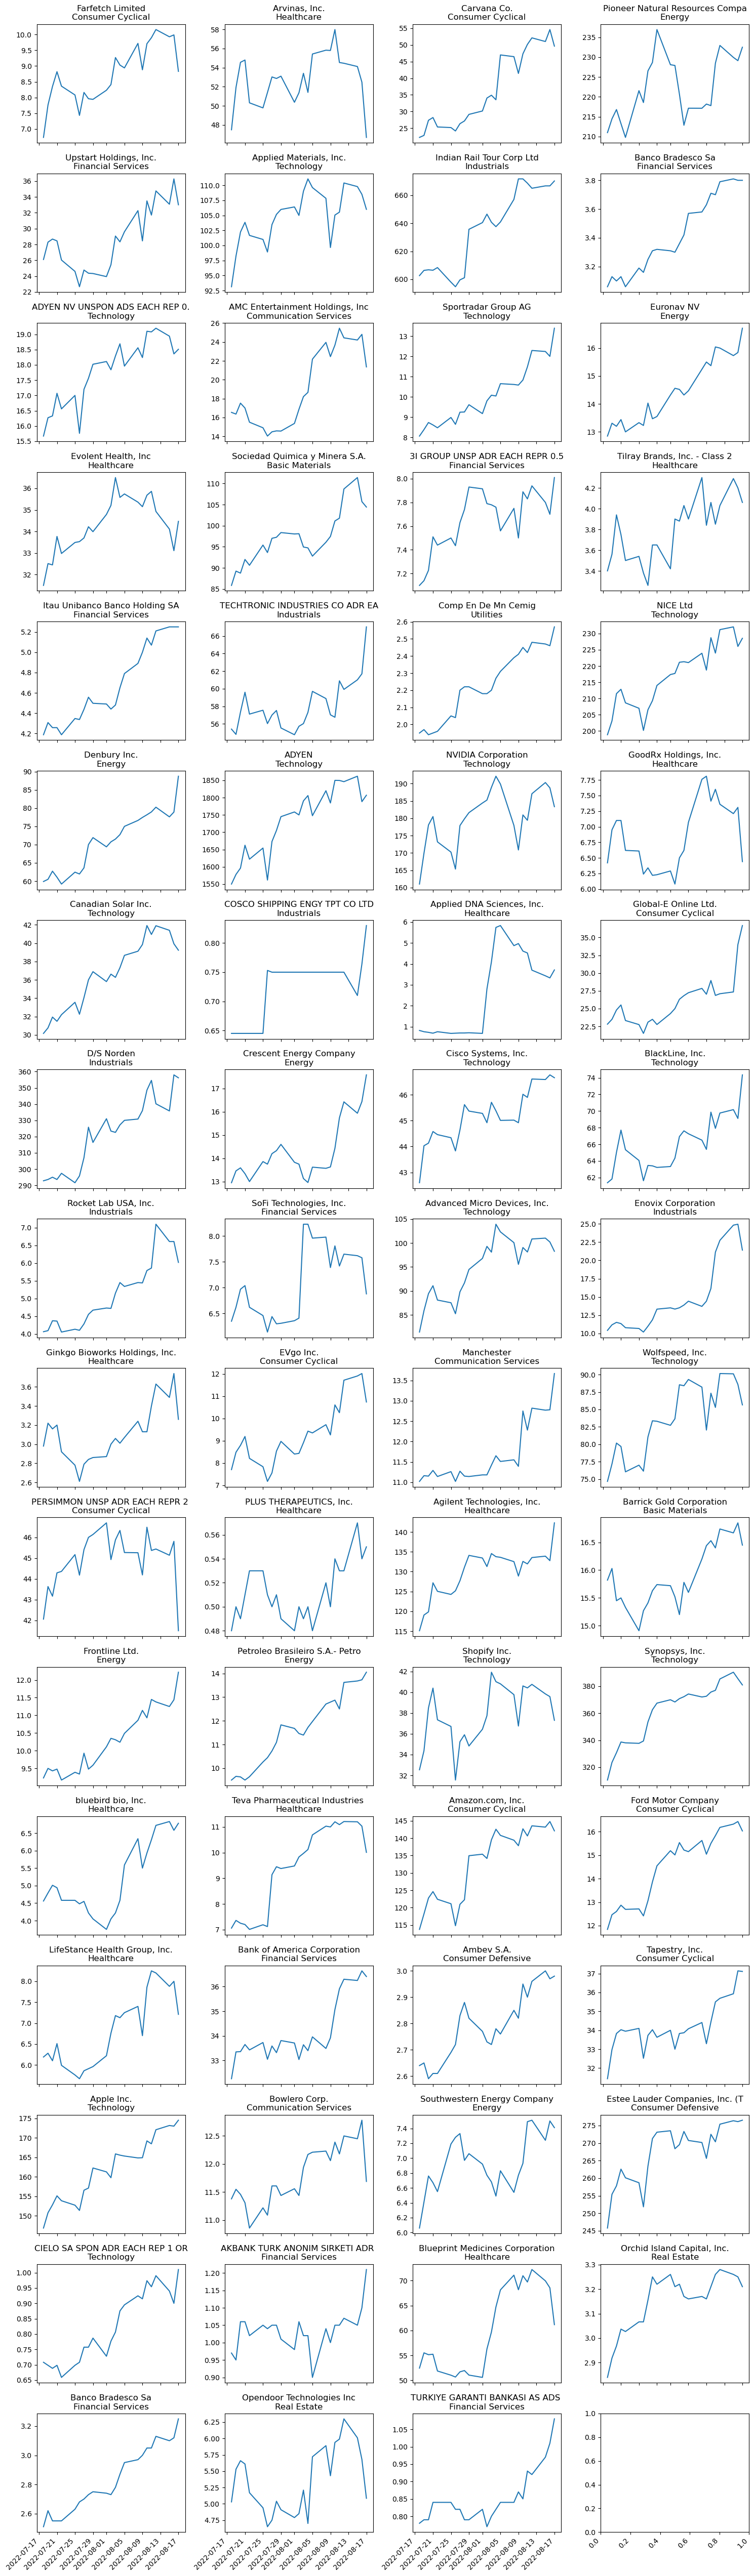

                          Cluster number: 2


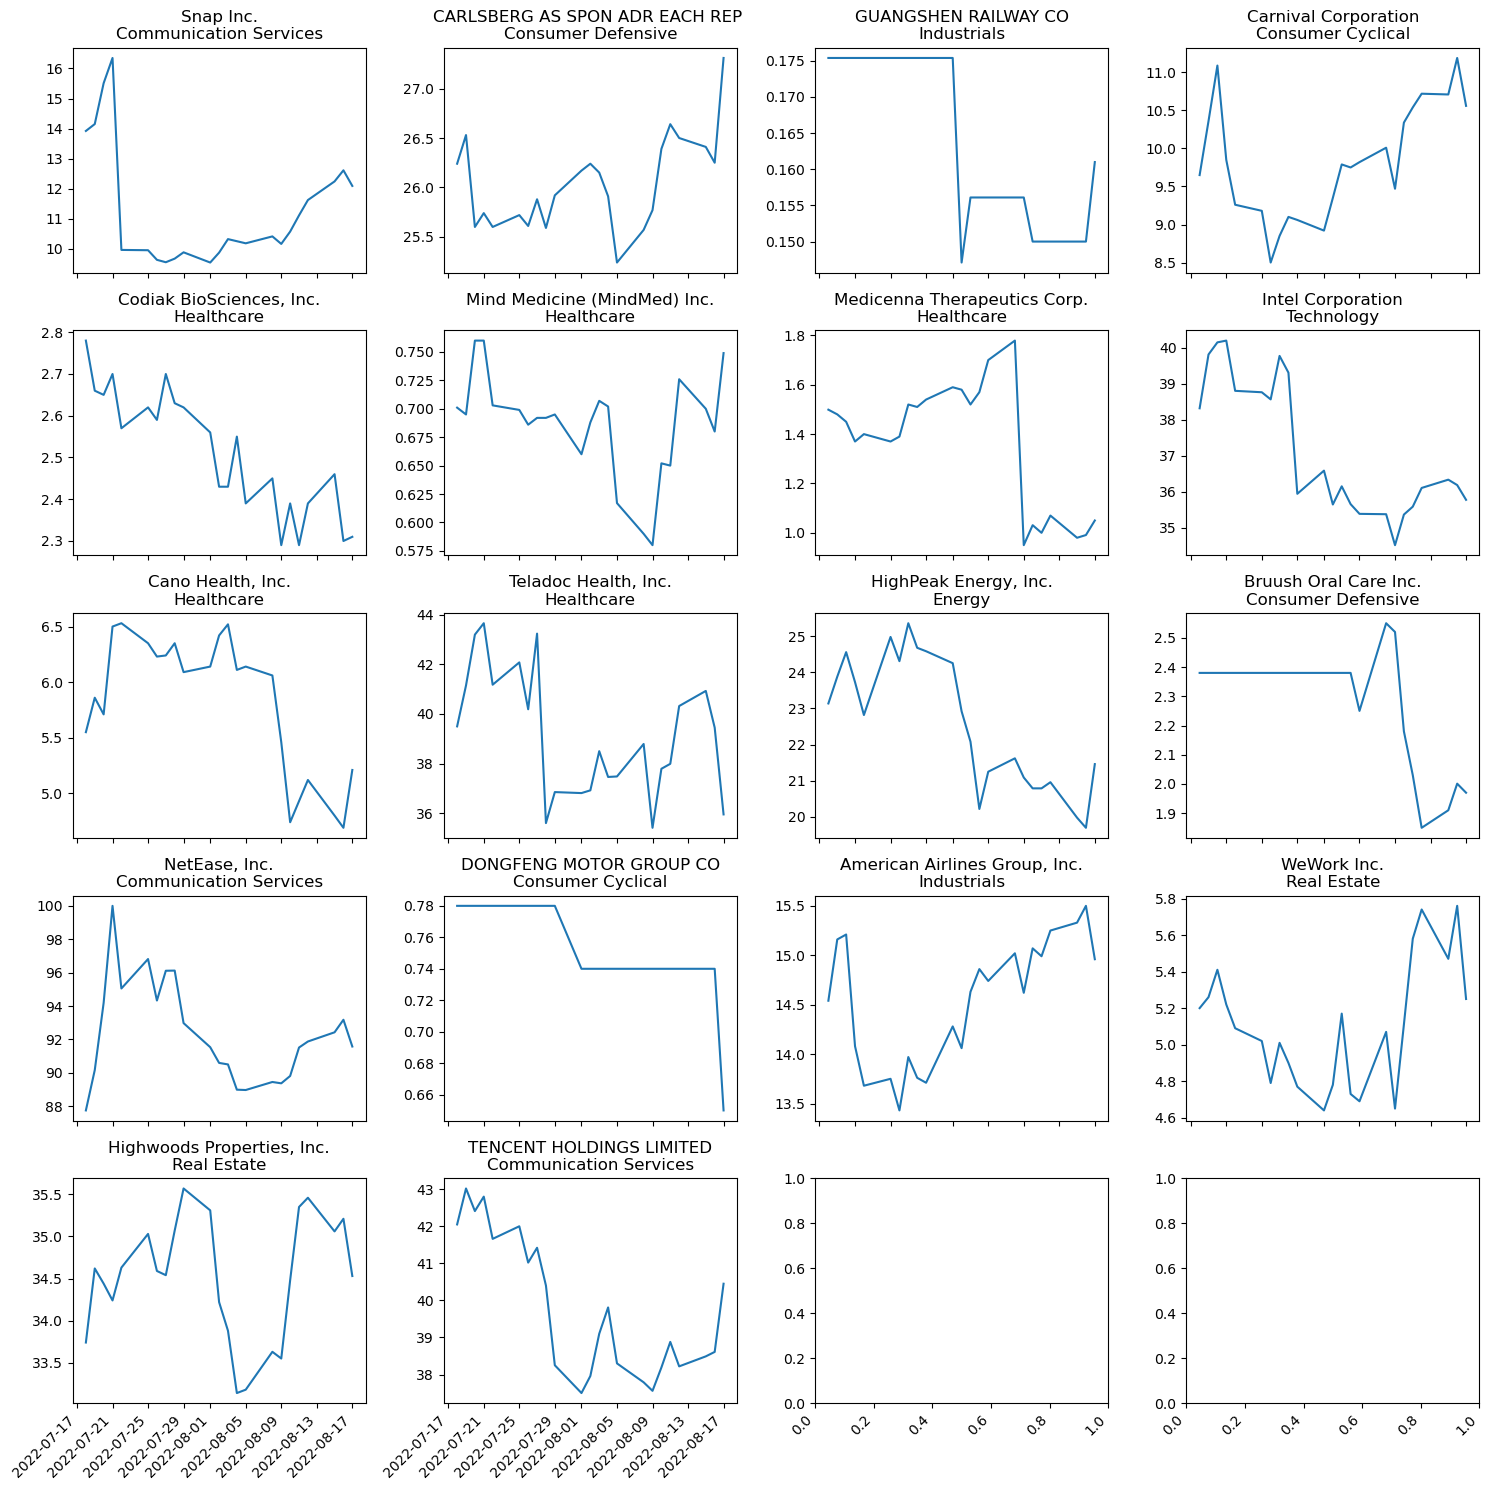

In [79]:
for cluster in range(n_clusters):
    print("=================================================================================")
    print(f"                          Cluster number: {cluster}")
    print("=================================================================================")
    plot_cluster_tickers(full_ticker_df[full_ticker_df.cluster==cluster])

### Переведем обратно в текстовый вид

In [42]:
string_tickers = []
for ticker in sax_transformed:
    string_tickers.append(get_string_sax(ticker.ravel(), n_sax_symbols))

string_tickers

['adcbbcfgfh',
 'hhbbbbccce',
 'agbdebdghf',
 'acfeeefbdf',
 'abbbbcdggh',
 'abbehgbccg',
 'cdbabbeffh',
 'acbbeehgcg',
 'gbbccfdaeh',
 'gggggdbbba',
 'bbbaceefhg',
 'egbabbdeeg',
 'abbbccdfgh',
 'abbaeegfgh',
 'bfcacbffdc',
 'ccbabbdggh',
 'dffddeeeef',
 'hgfggddcaa',
 'abbbcceffh',
 'ehfeedfaae',
 'abbbbedfgh',
 'abbcdfhggg',
 'feeffgghaa',
 'abcdeeccfh',
 'abbcggfeeg',
 'bebaccfgff',
 'ghggecbbab',
 'dedaaeehhc',
 'bbbbccdfgh',
 'bedccbcfcg',
 'aabcddefgg',
 'acbaceffgg',
 'ababedefgg',
 'abbadegfgh',
 'adbbefhfcf',
 'dfcbaacghh',
 'dfggfggfaa',
 'aabbddefhh',
 'fhggabccbe',
 'fgghhfbcbb',
 'aaafffffff',
 'bbbbbchhhg',
 'bdbbbceffe',
 'aaabdeefgh',
 'fffffffffa',
 'dddddddddd',
 'bccdecbcdh',
 'abbbfdfdfg',
 'aecbbbfefg',
 'bbbbcceffh',
 'bdbabbhhgf',
 'abbadfggfg',
 'bbbbcdddeh',
 'debabcdeeh',
 'bdbaccdefh',
 'afcceghgbc',
 'eeeeeeeeee',
 'bccbbcddfh',
 'ababddggeg',
 'bhhggcbbbd',
 'gggggccccc',
 'abddgggeff',
 'bcgdcbbcfg',
 'abbcffgfef',
 'ebabccbegh',
 'dagfededdd',
 'hddegdef

In [43]:
from tslearn.clustering import TimeSeriesKMeans
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(analyzer='char')
vectorized = vectorizer.fit_transform(string_tickers).toarray()
vectorized

array([[0.23583415, 0.4427287 , 0.53140623, 0.26278019, 0.        ,
        0.49763718, 0.25427786, 0.29090813],
       [0.        , 0.65452867, 0.58922194, 0.        , 0.1986025 ,
        0.        , 0.        , 0.43007763],
       [0.23522425, 0.44158375, 0.        , 0.52420122, 0.26797798,
        0.24817511, 0.50724053, 0.2901558 ],
       [0.1957731 , 0.18376128, 0.22056824, 0.21814183, 0.66910041,
        0.61965564, 0.        , 0.        ],
       [0.20506848, 0.76994532, 0.2310409 , 0.22849928, 0.        ,
        0.        , 0.44221224, 0.25295779],
       [0.21578379, 0.60763258, 0.48622665, 0.        , 0.24583054,
        0.        , 0.46531886, 0.26617543],
       [0.23117171, 0.65096392, 0.26045016, 0.25758502, 0.26336114,
        0.48779889, 0.        , 0.28515687],
       [0.21840093, 0.41000151, 0.49212386, 0.        , 0.4976242 ,
        0.        , 0.4709625 , 0.26940375],
       [0.25048334, 0.47022944, 0.56441531, 0.27910317, 0.28536181,
        0.26427432, 0.270072

In [82]:
vectorized.shape

(96, 8)

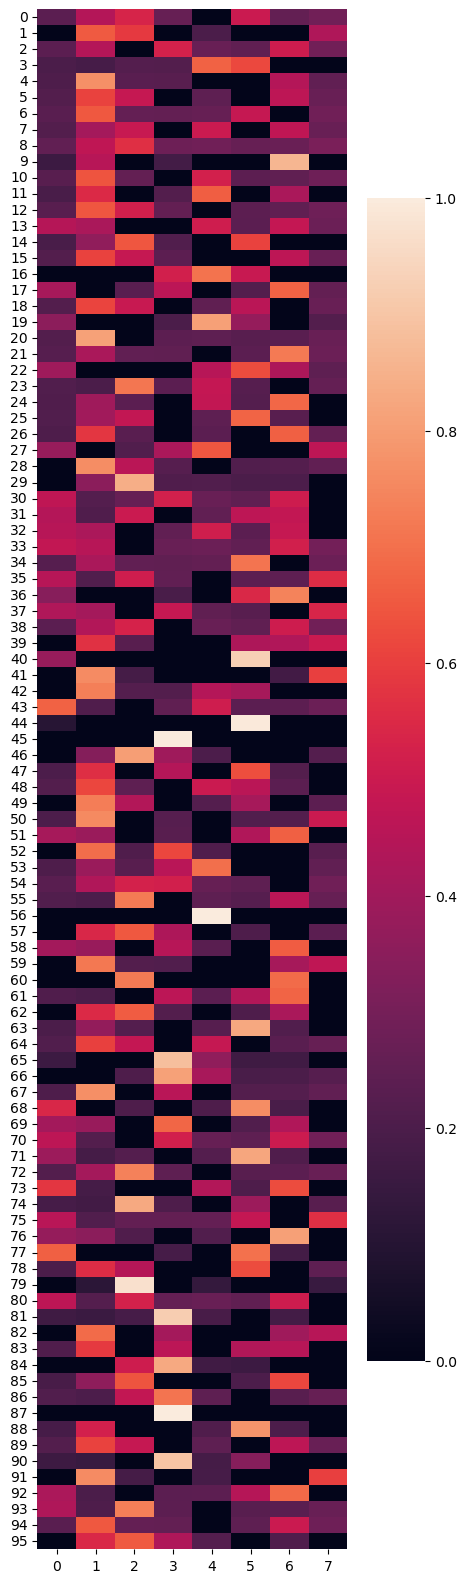

In [44]:
plt.figure(figsize=(5, 20))
sns.heatmap(vectorized);